<a href="https://colab.research.google.com/github/alhamhotaki/GenG-Model-for-Property-Investors/blob/main/GGMPI_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import error
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import folium
import ipywidgets as widgets
from IPython.display import display, clear_output

In [18]:
house_data = pd.read_csv('/content/drive/MyDrive/House_Dataset_Cleaned.csv')
house_data.head()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,...,floor_covering,HOA,sold_price_bin,total_bed_bath,sold_price_log,lot_acres_log,sold_price_category,zip,city,state_id
0,21530491,5300000.0,85637,-110.378200,31.356362,131.00,5272.00,1941,13,10.0,...,"Mexican Tile, Wood",0.000000,"(900000.0, 5300000.0]",23.0,15.483218,4.882802,Luxury,85637,Sonoita,AZ
1,21529082,4200000.0,85646,-111.045371,31.594213,4.68,10422.36,1997,2,2.0,...,"Natural Stone, Other",0.000000,"(900000.0, 5300000.0]",4.0,15.250595,1.736951,Luxury,85646,Tubac,AZ
2,3054672,4200000.0,85646,-111.040707,31.594844,4.68,10482.00,1997,2,3.0,...,"Natural Stone, Other: Rock",10.753904,"(900000.0, 5300000.0]",5.0,15.250595,1.736951,Luxury,85646,Tubac,AZ
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,...,"Ceramic Tile, Laminate, Wood",11.695749,"(900000.0, 5300000.0]",12.0,15.319588,6.457821,Luxury,85646,Tubac,AZ
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,...,"Carpet, Concrete",55.000000,"(900000.0, 5300000.0]",10.0,15.042648,1.437463,Luxury,85750,Tucson,AZ


# Property Investment Risk Model

To define the "Investment Risk" for properties, we can base it on several economic and property-related factors. Here are a few possible factors that could influence investment risk:

## Important features:
* Sold Price: Higher-priced properties might represent a higher risk
since they require more investment, but they could also bring higher returns. Conversely, lower-priced properties may carry less risk but could also have lower returns. Our intention is now to define the risk profile, while we will ignore the high returns as we lack sufficient data in our current dataset.

* Taxes: Higher property taxes may reduce overall profit, adding risk to the investment.

* Year Built: Older properties may require more maintenance and upgrades, increasing the risk.

* HOA (Homeowners Association) Fees: High HOA fees could affect profitability and add to the investment risk.

* Price volatility by ZIP code: This is one the important features of our current model. Price volatility measures how much prices fluctuate within a specific area and can indicate the stability or riskiness of property investments. Areas with high volatility might carry higher risk, as property values may fluctuate significantly.

## Risk Profile:
Considering the above important features, we will defien the risk profile for property investment model:

**1. High Risk:**
* High Sold Price: Top 25% of sold prices.
* High Price Volatility (CV): Top 25% of ZIP codes based on coefficient of variation.
* Older Properties: Built before 1980.
* High Maintenance Cost: Top 25% of combined property taxes and HOA fees.

**2. Medium Risk:**
* Moderate Sold Price: Middle 50% of sold prices.
* Moderate Price Volatility (CV): Middle 50% of ZIP codes based on coefficient of variation.
* Moderate Age: Built between 1980 and 2000.
* Moderate Maintenance Cost: Middle 50% of combined property taxes and HOA fees.

**3. Low Risk:**
* Low Sold Price: Bottom 25% of sold prices.
* Low Price Volatility (CV): Bottom 25% of ZIP codes based on coefficient of variation.
* Newer Properties: Built after 2000.
* Low Maintenance Cost: Bottom 25% of combined property taxes and HOA fees.

## Weighting System:
* 50% Weight on price volatility.
* 25% Weight on sold price.
* 15% Weight on maintenance cost (property taxes + HOA).
* 10% Weight on property age.

The weighting system is based on the financial and real estate market assumptions, while it could be also defined via feature importance matrixes derived from the dataset while developing the model.

## Feature Engineering:
1. Price Per Square Foot: By dividing the sold price by square footage, we created a normalized feature that helps compare properties more meaningfully. Sold price will vary depending on the size of the property, while price per square foot will be a solid feature for prediction.
2. Price Volatility: Calculating the coefficient of variation (CV) per ZIP code to understand how prices fluctuate, adding a key metric for investment risk.
3. Maintenance Cost: Summing property taxes and HOA fees to capture the ongoing costs of owning a property, which directly impacts risk.

### Price Per Square Foot:

In [19]:
house_data.columns

Index(['MLS', 'sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres',
       'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage',
       'kitchen_features', 'fireplaces', 'floor_covering', 'HOA',
       'sold_price_bin', 'total_bed_bath', 'sold_price_log', 'lot_acres_log',
       'sold_price_category', 'zip', 'city', 'state_id'],
      dtype='object')

In [20]:
house_data['price_per_sqrt_ft'] = house_data['sold_price'] / house_data['sqrt_ft']

### Price Volatility by Area:
Price volatility is typically measured as the standard deviation of the price per square foot, which represents the variation from the mean. The formula for standard deviation is:

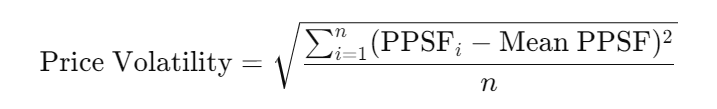

Alternatively, price volatility as a percentage, we can express it as the coefficient of variation (CV):

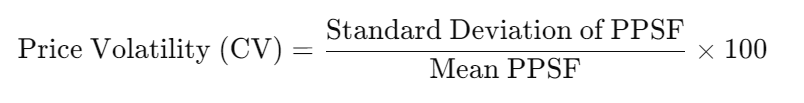


In [21]:
price_volatility = house_data.groupby('zipcode')['price_per_sqrt_ft'].agg(['mean', 'std'])
price_volatility['cv'] = price_volatility['std'] / price_volatility['mean']
house_data = pd.merge(house_data, price_volatility[['cv']], on='zipcode', how='left')

### Maintenance Cost:
Summing property taxes and HOA fees to capture the ongoing costs of owning a property, which directly impacts risk.

In [22]:
house_data['maintenance_cost'] = house_data['taxes'] + house_data['HOA']

## Risk Scoring and Labeling:

A weighted scoring system is a more systematic and quantitative way to determine the overall investment risk by considering the relative importance of each factor. Here is how we can structure and implement the system:
1. Assign Weights to Factors:
Each factor will contribute to the final risk score based on its importance. For example, we can use the following weights:
  * Price Volatility: 50% (since market fluctuations often represent a significant risk)
  * Sold Price: 30% (higher-priced properties may have higher risk)
  * Maintenance Cost: 10% (ongoing costs like taxes and HOA fees)
  * Age of Property: 10% (older properties may carry more risk due to maintenance issues)
2. Numerically Encode Risk Levels:
We will assign numerical values to risk levels:
  * High Risk: 3
  * Medium Risk: 2
  * Low Risk: 1
3. Calculate the Weighted Score:
For each property, the weighted score will be computed using the following formula:
Weighted Score=(Volatility Risk Score×0.5)+(Sold Price Risk Score×0.3)+(Maintenance Cost Risk Score×0.1)+(Age Risk Score×0.1)
4. Determine Final Risk Classification:
Based on the calculated weighted score:
  * High Risk: If the weighted score is ≥ 2.5.
  * Medium Risk: If the weighted score is between 1.5 and 2.5.
  * Low Risk: If the weighted score is ≤ 1.5.


In [23]:
house_data.columns

Index(['MLS', 'sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres',
       'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage',
       'kitchen_features', 'fireplaces', 'floor_covering', 'HOA',
       'sold_price_bin', 'total_bed_bath', 'sold_price_log', 'lot_acres_log',
       'sold_price_category', 'zip', 'city', 'state_id', 'price_per_sqrt_ft',
       'cv', 'maintenance_cost'],
      dtype='object')

In [24]:
# This code calculates a weighted risk score for properties based on four factors: price volatility, sold price,
# maintenance cost, and age of the property. Each factor is assigned a weight (volatility has the highest at 50%).
# The code maps each factor to a risk level (High, Medium, Low) using percentiles, then calculates the overall
# weighted risk score. Finally, it classifies each property as High, Medium, or Low risk based on this score.

weights = {
    'volatility': 0.5,
    'sold_price': 0.3,
    'maintenance_cost': 0.1,
    'age': 0.1
}

risk_mapping = {
    'High': 3,
    'Medium': 2,
    'Low': 1
}

sold_price_percentiles = house_data['sold_price'].quantile([0.25, 0.75])
maintenance_cost_percentiles = house_data['maintenance_cost'].quantile([0.25, 0.75])
cv_percentiles = house_data['cv'].quantile([0.25, 0.75])
year_built_threshold = 1987


house_data_clean = house_data.dropna().copy()


house_data_clean.loc[:, 'volatility_risk'] = house_data_clean.apply(
    lambda x: 'High' if x['cv'] >= cv_percentiles[0.75] else (
        'Low' if x['cv'] <= cv_percentiles[0.25] else 'Medium'), axis=1)

house_data_clean.loc[:, 'sold_price_risk'] = house_data_clean.apply(
    lambda x: 'High' if x['sold_price'] >= sold_price_percentiles[0.75] else (
        'Low' if x['sold_price'] <= sold_price_percentiles[0.25] else 'Medium'), axis=1)

house_data_clean.loc[:, 'maintenance_risk'] = house_data_clean.apply(
    lambda x: 'High' if x['maintenance_cost'] >= maintenance_cost_percentiles[0.75] else (
        'Low' if x['maintenance_cost'] <= maintenance_cost_percentiles[0.25] else 'Medium'), axis=1)

house_data_clean.loc[:, 'age_risk'] = house_data_clean.apply(
    lambda x: 'High' if x['year_built'] < year_built_threshold else 'Low', axis=1)

def calculate_weighted_risk_score(row):
    volatility_risk_score = risk_mapping[row['volatility_risk']]
    sold_price_risk_score = risk_mapping[row['sold_price_risk']]
    maintenance_risk_score = risk_mapping[row['maintenance_risk']]
    age_risk_score = risk_mapping[row['age_risk']]

    weighted_score = (
        (volatility_risk_score * weights['volatility']) +
        (sold_price_risk_score * weights['sold_price']) +
        (maintenance_risk_score * weights['maintenance_cost']) +
        (age_risk_score * weights['age'])
    )

    return weighted_score

def classify_by_weighted_score(weighted_score):
    if weighted_score >= 2.5:
        return 'High'
    elif weighted_score <= 1.5:
        return 'Low'
    else:
        return 'Medium'


house_data_clean.loc[:, 'weighted_score'] = house_data_clean.apply(calculate_weighted_risk_score, axis=1)

house_data_clean.loc[:, 'final_risk'] = house_data_clean['weighted_score'].apply(classify_by_weighted_score)

house_data_clean


,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,...,state_id,price_per_sqrt_ft,cv,maintenance_cost,volatility_risk,sold_price_risk,maintenance_risk,age_risk,weighted_score,final_risk
0,21530491,5300000.0,85637,-110.378200,31.356362,131.00,5272.00,1941,13,10.0,...,AZ,724.517820,0.534351,5272.000000,High,High,Medium,High,2.9,High
1,21529082,4200000.0,85646,-111.045371,31.594213,4.68,10422.36,1997,2,2.0,...,AZ,575.342466,0.902211,10422.360000,High,High,High,Low,2.8,High
2,3054672,4200000.0,85646,-111.040707,31.594844,4.68,10482.00,1997,2,3.0,...,AZ,1617.559418,0.902211,10492.753904,High,High,High,Low,2.8,High
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,...,AZ,615.156639,0.902211,8430.275749,High,High,High,High,3.0,High
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,...,AZ,533.372420,0.247637,15448.000000,Medium,High,High,Low,2.3,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,21909379,535000.0,85718,-110.922291,32.317496,0.18,4414.00,2002,3,2.0,...,AZ,254.036087,0.230100,4612.000000,Low,Low,Low,Low,1.0,Low
4995,21810382,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3.0,...,AZ,137.461816,0.150047,2017.000000,Low,Low,Low,Low,1.0,Low
4996,21908591,550000.0,85750,-110.858556,32.316373,1.42,4822.01,1990,4,3.0,...,AZ,237.273512,0.247637,4865.010000,Medium,Low,Medium,Low,1.6,Medium
4998,21900515,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4.0,...,AZ,147.690655,0.278275,5822.930000,High,Low,Medium,Low,2.1,Medium


# The GenG Model for Property Investors (GGMPI)

The goal is to develop a function that takes specific inputs (like ZIP code, longitude, latitude, or other property features) and predicts the investment risk using the logistic regression model we built.

1. Inputs to the Function:
  * ZIP Code: Given by the user.
  * Price Per Square Footage: Provided by the user.
  * Year Built: The year the property was built.
  * Maintenance Cost: The sum of HOA and taxes.

2. Price Volatility Calculation:
Price volatility is calculated using the standard deviation (or coefficient of variation, CV) of price per square foot in each locatin (long+lat). The function should calculate this based on the coordinates provided. However, if the long+lat isn't found, the function should calculate volatility based on nearby long+lat. Here is how it should be done:
  * Check if the Long+Lat Exists in the Dataset. If the Long+Lat exists in the dataset, calculate price volatility directly using the coefficient of variation (CV) of price per square foot within that Long+Lat.
  * If the Long+Lat is not found in the dataset, the function can:
    * Find Nearby Long+Lat Using Latitude/Longitude: Use a nearest neighbor search based on geographical distance (e.g., Haversine distance) to find the closest Long+Lat that exists in the dataset. This would use the latitude/longitude of the Long+Lat to estimate nearby areas.
    * Fallback on Regional Averages: If the nearest Long+Lat cannot be found, use a broader region's (state, county, etc.) average price volatility for the calculation.



In [25]:
house_data_clean.columns

Index(['MLS', 'sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres',
       'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage',
       'kitchen_features', 'fireplaces', 'floor_covering', 'HOA',
       'sold_price_bin', 'total_bed_bath', 'sold_price_log', 'lot_acres_log',
       'sold_price_category', 'zip', 'city', 'state_id', 'price_per_sqrt_ft',
       'cv', 'maintenance_cost', 'volatility_risk', 'sold_price_risk',
       'maintenance_risk', 'age_risk', 'weighted_score', 'final_risk'],
      dtype='object')

In [26]:
house_data_clean

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,...,state_id,price_per_sqrt_ft,cv,maintenance_cost,volatility_risk,sold_price_risk,maintenance_risk,age_risk,weighted_score,final_risk
0,21530491,5300000.0,85637,-110.378200,31.356362,131.00,5272.00,1941,13,10.0,...,AZ,724.517820,0.534351,5272.000000,High,High,Medium,High,2.9,High
1,21529082,4200000.0,85646,-111.045371,31.594213,4.68,10422.36,1997,2,2.0,...,AZ,575.342466,0.902211,10422.360000,High,High,High,Low,2.8,High
2,3054672,4200000.0,85646,-111.040707,31.594844,4.68,10482.00,1997,2,3.0,...,AZ,1617.559418,0.902211,10492.753904,High,High,High,Low,2.8,High
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,...,AZ,615.156639,0.902211,8430.275749,High,High,High,High,3.0,High
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,...,AZ,533.372420,0.247637,15448.000000,Medium,High,High,Low,2.3,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,21909379,535000.0,85718,-110.922291,32.317496,0.18,4414.00,2002,3,2.0,...,AZ,254.036087,0.230100,4612.000000,Low,Low,Low,Low,1.0,Low
4995,21810382,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3.0,...,AZ,137.461816,0.150047,2017.000000,Low,Low,Low,Low,1.0,Low
4996,21908591,550000.0,85750,-110.858556,32.316373,1.42,4822.01,1990,4,3.0,...,AZ,237.273512,0.247637,4865.010000,Medium,Low,Medium,Low,1.6,Medium
4998,21900515,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4.0,...,AZ,147.690655,0.278275,5822.930000,High,Low,Medium,Low,2.1,Medium


In [33]:
# This code defines functions to calculate the coefficient of variation (CV) based on nearby properties' price per square foot.
# It then trains a K-Nearest Neighbors (KNN) model to predict property investment risk based on several features,
# including price per square foot, year built, maintenance cost, and CV. The code also allows for user input to
# predict the investment risk of a new property using the trained KNN model. Accuracy of the model is calculated on a test set.



def compute_cv(price_per_sqft_values):
    """
    Computes the coefficient of variation (CV) for a list of price per square foot values.
    CV = standard deviation / mean
    """
    if len(price_per_sqft_values) == 0:
        return None
    mean = np.mean(price_per_sqft_values)
    std_dev = np.std(price_per_sqft_values)
    return std_dev / mean if mean != 0 else None


def find_nearest_and_compute_cv(lat, long, house_data_clean, initial_threshold=10, max_threshold=50, step=10):
    """
    Finds nearby properties using latitude and longitude and calculates the price volatility (CV)
    based on nearby properties' price per square foot. Gradually increases the search threshold if no properties are found.
    """
    threshold = initial_threshold

    print(f"Searching for nearby properties for lat: {lat}, long: {long}")
    while threshold <= max_threshold:
        price_per_sqft_values = []
        for index, row in house_data_clean.iterrows():
            try:
                property_lat, property_long = float(row['latitude']), float(row['longitude'])
                distance = geodesic((lat, long), (property_lat, property_long)).miles
                if distance < threshold:
                    price_per_sqft_values.append(row['price_per_sqrt_ft'])
            except ValueError as ve:
                print(f"Skipping row with invalid coordinates at index {index}: {ve}")
                continue

        if price_per_sqft_values:
            return compute_cv(price_per_sqft_values)
        threshold += step

    print("No properties found within the search range.")
    return error


def train_knn_model(X_train, y_train, n_neighbors=5):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    return knn_model


def predict_investment_risk_knn(price_per_sqft, year_built, maintenance_cost, latitude, longitude, house_data_clean, knn_model, scaler):
    """
    Predict investment risk based on the given parameters and the nearest properties' CV if needed.
    """

    exact_match = house_data_clean[(house_data_clean['latitude'] == latitude) &
                                   (house_data_clean['longitude'] == longitude)]

    if not exact_match.empty:

        cv = exact_match['cv'].values[0]
    else:

        cv = find_nearest_and_compute_cv(latitude, longitude, house_data_clean)
        if cv is None:
            raise ValueError("No nearby properties found to compute CV, even after expanding search radius.")


    features = np.array([[price_per_sqft, year_built, maintenance_cost, cv]])


    features_scaled = scaler.transform(features)


    risk_prediction = knn_model.predict(features_scaled)

    return risk_prediction[0]


def get_user_input():
    """
    Function to get user input for property features.
    """
    try:
        price_per_sqft = float(input("Enter price per square foot: "))
        year_built = int(input("Enter year built: "))
        maintenance_cost = float(input("Enter maintenance cost: "))
        latitude = float(input("Enter latitude: "))
        longitude = float(input("Enter longitude: "))
    except ValueError as e:
        print("Invalid input, please enter the correct values.")
        return get_user_input()

    return price_per_sqft, year_built, maintenance_cost, latitude, longitude

def main():

    label_encoder = LabelEncoder()
    house_data_clean.loc[:, 'risk_category'] = label_encoder.fit_transform(house_data_clean['final_risk']) + 1


    X = house_data_clean[['price_per_sqrt_ft', 'year_built', 'maintenance_cost', 'cv']].values
    y = house_data_clean['risk_category'].values


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    knn_model = train_knn_model(X_train_scaled, y_train, n_neighbors=3)


    y_pred = knn_model.predict(X_test_scaled)


    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Test Set Accuracy: {accuracy * 100:.2f}%")


    print("\n--- Enter details of the new property ---")
    price_per_sqft, year_built, maintenance_cost, latitude, longitude = get_user_input()

    risk = predict_investment_risk_knn(
        price_per_sqft=price_per_sqft,
        year_built=year_built,
        maintenance_cost=maintenance_cost,
        latitude=latitude,
        longitude=longitude,
        house_data_clean=house_data_clean,
        knn_model=knn_model,
        scaler=scaler
    )

    print("Predicted Risk for New Property:", risk)


if __name__ == "__main__":
    main()

KNN Test Set Accuracy: 81.86%

--- Enter details of the new property ---
Enter price per square foot: 284
Enter year built: 1984
Enter maintenance cost: 1720
Enter latitude: 32.305000
Enter longitude: -110.826770
Searching for nearby properties for lat: 32.305, long: -110.82677
Predicted Risk for New Property: 3


# Spatial Overview

In [28]:
house_data_clean.to_csv('house_data_clean_RiskModel.csv', index = False)

In [29]:
# This code groups the properties by ZIP code and calculates two metrics for each ZIP code:
# 1. The average weighted risk score for properties within that ZIP code.
# 2. The most common (mode) final risk classification (High, Medium, Low) for properties in that ZIP code.
# The results are then reset into a structured format for further analysis.


risk_factors = house_data_clean.groupby('zipcode').agg({
    'weighted_score': 'mean',
    'final_risk': lambda x: x.mode()[0]
}).reset_index()
average_risk_score = house_data_clean.groupby('zipcode')['weighted_score'].mean().reset_index()


In [39]:
# This code allows the user to input a ZIP code and visualizes the associated property risk on a map.
# For the given ZIP code, it calculates the average weighted risk score, determines the risk level (High, Medium, Low),
# and displays a marker on a map at the location of the first property in that ZIP code.
# The map marker's color corresponds to the risk level (red for High, orange for Medium, green for Low),
# and it includes a label showing the average risk score.
# The user interacts with a text box to input the ZIP code, and a button triggers the map update.

data = house_data_clean


def update_map_with_risk(zip_code):
    clear_output(wait=True)


    zip_data = data[data['zipcode'] == int(zip_code)]

    if zip_data.empty:
        print(f"Zip code {zip_code} not found in the dataset.")
        return


    avg_score = round(zip_data['weighted_score'].mean(), 1)


    lat = zip_data['latitude'].iloc[0]
    lon = zip_data['longitude'].iloc[0]


    if avg_score >= 2.5:
        marker_color = 'red'
        risk_label = 'High Risk'
    elif 1.5 <= avg_score < 2.5:
        marker_color = 'orange'
        risk_label = 'Medium Risk'
    else:
        marker_color = 'green'
        risk_label = 'Low Risk'


    m = folium.Map(location=[lat, lon], zoom_start=12)


    folium.Marker(
        location=[lat, lon],
        popup=f"Zip Code: {zip_code}\nAverage Risk Score: {avg_score:.1f} ({risk_label})",
        icon=folium.Icon(color=marker_color, icon="info-sign", icon_size=(40, 40))
    ).add_to(m)


    folium.map.Marker(
        [lat + 0.001, lon],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12pt; color : {marker_color};"><b>{risk_label}</b></div>"""
        )
    ).add_to(m)


    display(m)


zip_code_input = widgets.Text(
    description="Zip Code:",
    placeholder="Enter a zip code"
)


update_button = widgets.Button(description="Update Map")


def on_update_button_clicked_with_risk(b):
    zip_code = zip_code_input.value
    if zip_code.isdigit():
        update_map_with_risk(zip_code)
    else:
        print("Please enter a valid zip code.")


update_button.on_click(on_update_button_clicked_with_risk)


display(zip_code_input, update_button)


In [31]:
house_data_clean

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,...,price_per_sqrt_ft,cv,maintenance_cost,volatility_risk,sold_price_risk,maintenance_risk,age_risk,weighted_score,final_risk,risk_category
0,21530491,5300000.0,85637,-110.378200,31.356362,131.00,5272.00,1941,13,10.0,...,724.517820,0.534351,5272.000000,High,High,Medium,High,2.9,High,1
1,21529082,4200000.0,85646,-111.045371,31.594213,4.68,10422.36,1997,2,2.0,...,575.342466,0.902211,10422.360000,High,High,High,Low,2.8,High,1
2,3054672,4200000.0,85646,-111.040707,31.594844,4.68,10482.00,1997,2,3.0,...,1617.559418,0.902211,10492.753904,High,High,High,Low,2.8,High,1
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,...,615.156639,0.902211,8430.275749,High,High,High,High,3.0,High,1
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,...,533.372420,0.247637,15448.000000,Medium,High,High,Low,2.3,Medium,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,21909379,535000.0,85718,-110.922291,32.317496,0.18,4414.00,2002,3,2.0,...,254.036087,0.230100,4612.000000,Low,Low,Low,Low,1.0,Low,2
4995,21810382,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3.0,...,137.461816,0.150047,2017.000000,Low,Low,Low,Low,1.0,Low,2
4996,21908591,550000.0,85750,-110.858556,32.316373,1.42,4822.01,1990,4,3.0,...,237.273512,0.247637,4865.010000,Medium,Low,Medium,Low,1.6,Medium,3
4998,21900515,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4.0,...,147.690655,0.278275,5822.930000,High,Low,Medium,Low,2.1,Medium,3
